# Soiling model demo and cleaning schedule assessment
The below code shows how to use the soiling model for a given solar field and assess the impact of a desired cleaning schedule.

In [2]:
import soiling_model.base_models as smb
import soiling_model.field_models as smf
import soiling_model.utilities as smu
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

d = "woomera_demo/"
file_params = d+"parameters.xlsx"
file_weather = d+'woomera_data.xlsx'

file_SF = d+'SF_woomera_SolarPILOT.csv'             # solar field of 48 sectors located in Woomera
climate_file = d+'woomera_location_modified.epw'    # only used for optical efficiency computation

n_trucks = 4         # number of trucks
n_cleans = 10        # number of cleanings in time interval
cleaning_rate = 330 # cleaning_rate = 330  # heliostats cleaned per truck per day used to control sectorisation of heliostat field, leave blank to calculate using parameter values

# Instantiate Model
Location and solar field parameters are imported and processed to set the required inputs to the subsequent sections of the model.

`dust_types` has to be chosen according to the dust measurements, it can be either "PMX", or "TSP"



Loading data from woomera_demo/parameters.xlsx ... 

Importing constants
Using config specified cleaning rate: 330.0 heliostats/shift
Grid size: 5 x 6 = 30 sectors
Sectors per truck: 1
Effective cleaning rate: 326.6 heliostats/shift
Error from target: 1.0%
Sectorizing with 6 angular and 5 radial sectors
Importing site data (weather,time). Using dust_type = PM10, test_length = 364 days
Importing AirTemp data as air_temp...
Importing WindSpeed data as wind_speed...
Importing DNI data as dni...
Importing RH data as relative_humidity...
Importing pm10 data...
Length of simulation for file woomera_demo/woomera_data.xlsx: 364 days
Importing dust properties for each experiment
Added PM10 attribute to dust class to all experiment dust classes
Loading source (normalized) intensity from woomera_demo/woomera_data.xlsx


(<Figure size 1200x1000 with 1 Axes>,
 <Axes: title={'center': 'Solar Field Sectors'}, xlabel='Distance from receiver - X [m]', ylabel='Distance from receiver - Y [m]'>)

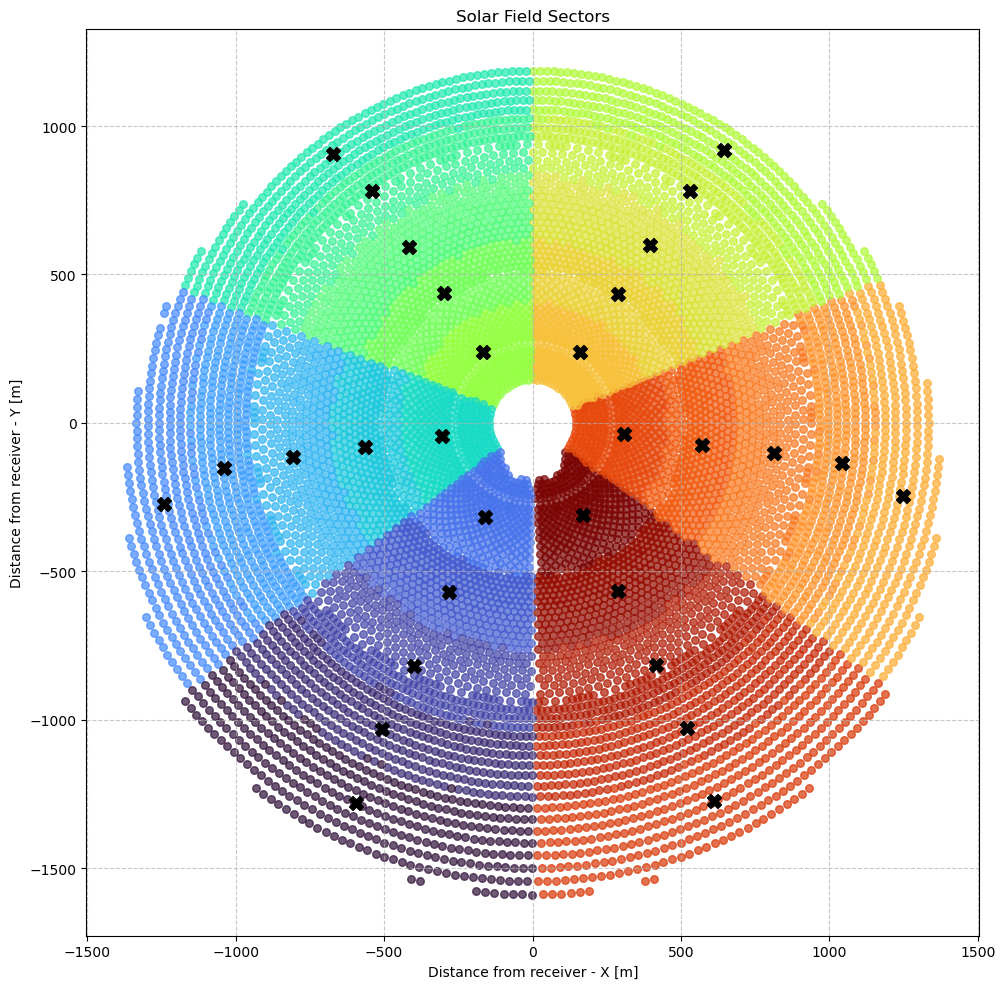

In [3]:
imodel = smf.field_model(file_params,file_SF, cleaning_rate=cleaning_rate)
sim_data = smb.simulation_inputs(file_weather,dust_type="PM10")
plant = smf.central_tower_plant()
plant.import_plant(file_params)
imodel.helios.sector_plot()

In [4]:
# Extinction weights pre processing
compute_lookupt_table = True

acceptance_min = 0.007 # [rad]
acceptance_max = 0.025 # [rad]
acceptance_step = 1000

if imodel.loss_model == 'mie' and compute_lookupt_table ==  True:
   print("Pre-processing extinction weights for mie scattering...")
   for f in list(sim_data.file_name.keys()):
      acceptance_angles_range = {f : np.linspace(acceptance_min, acceptance_max, acceptance_step)}
   imodel.helios.compute_extinction_weights_lookup_table(sim_data,acceptance_angles_range,verbose=True,save=True,options={'grid_size_x':250})

Pre-processing extinction weights for mie scattering...
Loss Model is mie. Computing extinction coefficients ... 


File 0:   0%|          | 0/1000 [00:00<?, ?it/s, acceptance angle 7.00 mrad]

	 Acceptance angle cosine = 0.999976
	 Acceptance angle cosine = 0.999975
	 Acceptance angle cosine = 0.999975
	 Acceptance angle cosine = 0.999975
	 Acceptance angle cosine = 0.999975
	 Acceptance angle cosine = 0.999975
	 Acceptance angle cosine = 0.999975
	 Acceptance angle cosine = 0.999975
	 Acceptance angle cosine = 0.999974
	 Acceptance angle cosine = 0.999974
	 Acceptance angle cosine = 0.999974
	 Acceptance angle cosine = 0.999974
	 Acceptance angle cosine = 0.999974
	 Acceptance angle cosine = 0.999974
	 Acceptance angle cosine = 0.999974
	 Acceptance angle cosine = 0.999974
	 Acceptance angle cosine = 0.999973
	 Acceptance angle cosine = 0.999973
	 Acceptance angle cosine = 0.999973
	 Acceptance angle cosine = 0.999973
	 Acceptance angle cosine = 0.999973
	 Acceptance angle cosine = 0.999973
	 Acceptance angle cosine = 0.999973
	 Acceptance angle cosine = 0.999973
	 Acceptance angle cosine = 0.999972
	 Acceptance angle cosine = 0.999972
	 Acceptance angle cosine = 0.999972
	

# Sun and heliostat angles
The model proceeds to compute the relevant sun angles (azimuth and zenith) that are required to then evaluate the movement of the heliostats depending on plant design and time of the day.

In [5]:
imodel.sun_angles(sim_data)
imodel.helios_angles(plant)

Calculating sun apparent movement and angles for 1 simulations


c:\Users\n12118907\OneDrive - Queensland University of Technology\Documents\GitHub\HelioSoil\soiling_model\field_models.py:186: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  time_utc = [t.replace(tzinfo=timezone) for t in np.array(sim_in.time[f].dt.to_pydatetime())]


Calculating heliostat movement and angles for 1 simulations
Second surface model


c:\Users\n12118907\AppData\Local\miniconda3\envs\cpv_sim\Lib\site-packages\pysolar\numeric.py:62: UserWarning: no explicit representation of timezones available for np.datetime64
  dd = numpy.array(d, dtype='datetime64[D]')
c:\Users\n12118907\AppData\Local\miniconda3\envs\cpv_sim\Lib\site-packages\pysolar\numeric.py:63: UserWarning: no explicit representation of timezones available for np.datetime64
  dy = numpy.array(d, dtype='datetime64[Y]')


# Computing extinction weighting for deposited dust
Two cases:
1) If the loss model is `geometry` then the extinction multipliers are all 1, indicating that the area loss at near-normal incidence is equal to the cross-sectional area of the particle. 
2) If the loss model is `mie` then the extinction multiplier is computed by 
    - Approximately computing the acceptance angles of the heliostats to the tower (assumes no blocking/shading and a conical acceptance area)
    - Computing the extinction weights using `miepython` 

In [ ]:
imodel.compute_acceptance_angles(plant)
imodel.helios.compute_extinction_weights_new(sim_data,imodel.loss_model,lookup_tables=True,verbose=True,options={'grid_size_x':250})
# imodel.helios.compute_extinction_weights(sim_data,imodel.loss_model,verbose=True,options={'grid_size_x':250})

Acceptance angle range: (7.3, 24.4) [mrad]
Loss Model is mie. Computing extinction coefficients ... 
Reading values from lookup tables...
... Done!


# Calculate area lost during each time step due to soiling
The soiling model is implemented in the following steps. 
* The amount of dust falling towards the mirrors is calculated in *imodel.deposition_flux*
* The balance between adhesive and removal forces acting on the deposited particles is assessed in *imodel.adhesion_removal*. 
* Since the heliostats are assumed to be stowed almost vertically at night, all particles that would fall on those conditions, are considered to be instantaneously removed (in practical terms, those particles never deposit on the surface).

For further information, please refer to [1] from the README.md file.

Once the amount of dust particles adhering on the surface of the heliostats has been computed, *imodel.calculate_delta_soilied_area* computes the area of the heliostats that is affected by the adhering dust particles.

In [7]:
imodel.deposition_flux(sim_data)
imodel.adhesion_removal(sim_data)
imodel.calculate_delta_soiled_area(sim_data)

No value for hrz0 supplied. Using value in self.hrz0 = 50.0.
Calculating deposition velocity for each of the 1 simulations
Aerodynamic resistance is considered
Calculating adhesion/removal balance
  Using common stow_tilt. Assumes all heliostats are stored at helios.stow_tilt at night.
Calculating soil deposited in a timestep [m^2/m^2]


The deposition area flux can be computed and shown for a given pair of air temperature (°C) and wind speed (m/s).

Loss model is mie 
No value for hrz0 supplied. Using value in self.hrz0 = 50.0.
Calculating deposition velocity for each of the 1 simulations
Aerodynamic resistance is considered
Calculating soil deposited in a timestep [m^2/m^2]


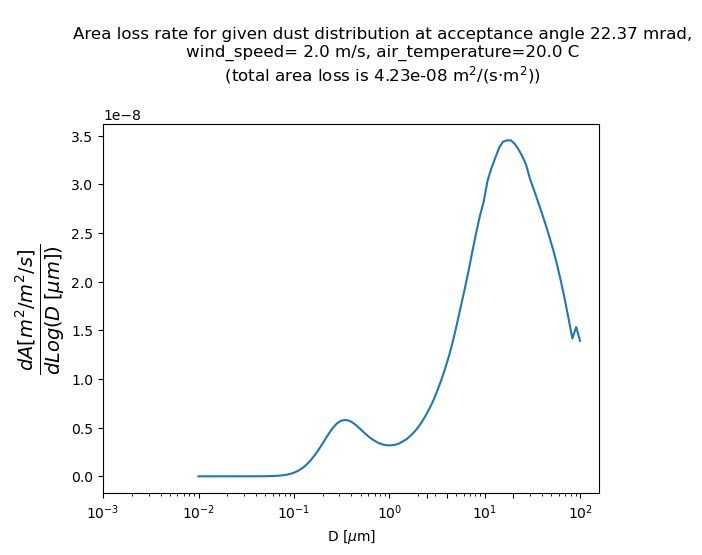

In [8]:
airT = 20
windS = 2.0
experiment = 0
heliostat_id = 0
imodel.plot_area_flux(sim_data,experiment,heliostat_id,airT,windS,tilt=0.0)

# Specify cleaning schedule and simulate its impact
The cleaning schedule specified by $n_{trucks}$ and $n_{cleans}$ is subsequently applied. This follows the *Heuristic Approach* described in [3] from README.md. Eventually, the reflectance losses are computed.

In [9]:
cleans = smu.simple_annual_cleaning_schedule(imodel.helios.tilt[0].shape[0],n_trucks,n_cleans,dt=sim_data.dt[0]/3600.00)
cleans = imodel.reflectance_loss(sim_data,{0:cleans})

Calculating reflectance losses with cleaning for 1 simulations


# Analysis and visulization of the results

The optical efficiency is computed for every sector (as the average of each heliostat belonging to the sector) in the field using a look-up table with `n_az` solar azimuth angles and `n_el` solar elevation angles. It eventually computes the average for the whole solar field.

In [10]:
soiling_factor = imodel.helios.soiling_factor[0] # zero for the first "run"
field_average_soiling_factor = np.mean(soiling_factor,axis=0)
imodel.optical_efficiency(plant,sim_data,climate_file,verbose=True,n_az=10,n_el=10)
field_average_clean_optical_efficiency = np.mean(imodel.helios.optical_efficiency[0]*imodel.helios.nominal_reflectance,axis=0)

Computing optical efficiency grid:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

The below computes the resulting optical efficiency for each sector in soiled conditions. An average value for the whole field is also computed.

In [ ]:
soiled_optical_efficiency = imodel.helios.optical_efficiency[0]*soiling_factor*imodel.helios.nominal_reflectance
field_average_soiled_optical_efficiency = np.mean(soiled_optical_efficiency,axis=0)

The next section allows to plot the results of the model, including the average soiling factor, the soiling factor for a selected sector, and the optical efficiency of the solar field both in clean and soiled state.

In [ ]:
t = sim_data.time[0]
sec_plot = 0 # choose sector for plot

t0 = 96
t1 = 96+96 # hours of the year for the zoomed-in plot

# examine field soiling - field average
fig, ax = plt.subplots()
ax.plot_date(t,field_average_soiling_factor,"-")
ax.set_xlim(t[t0],t[t1])
ax.set_xlabel("Time")
ax.set_ylabel("Field-Averaged Soiling Factor [-]")
plt.xticks(rotation=45)

# examine sector soiling 
fig, ax = plt.subplots()
ax.plot_date(t,soiling_factor[sec_plot],"-")
ax.set_xlim(t.iloc[0],t.iloc[-1])
ax.set_xlabel("Time")
ax.set_ylabel("Soiling Factor [-]")
ax.set_title("Sector {0:d}".format(sec_plot))
plt.xticks(rotation=45)

In [ ]:
# examine optical efficiency - field average
t0 = 96
t1 = 96+96 # hours of the year for the zoomed-in plot

# t0 = 4000
# t1 = 4000+96 # hours of the year for the zoomed-in plot

fig, ax = plt.subplots(ncols=2,sharey=True,figsize=(12,5))
ax[0].plot_date(t,field_average_clean_optical_efficiency,"-",label='clean')
ax[0].plot_date(t,field_average_soiled_optical_efficiency,"-",label='soiled')
ax[0].set_xlim(t.iloc[0],t.iloc[-1])
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Field-Averaged Optical Efficiency [-]")
ax[0].set_title("Full year")
for label in ax[0].get_xticklabels():
    label.set(rotation=45)

ax[1].plot_date(t,field_average_clean_optical_efficiency,"-",label='clean')
ax[1].plot_date(t,field_average_soiled_optical_efficiency,"-",label='soiled')
ax[1].set_xlim(t[t0],t[t1+10])
ax[1].set_xlabel("Time")
ax[1].set_title("Zoom in")
plt.xticks(rotation=45)
plt.legend()

The next plot allows to assess the tilt angle of heliostats, chosing the time frame in hours between `h_start` and `h_end`

In [ ]:
# examine tilts
h_start = 0
h_end = 48


Nhelios = imodel.helios.x.shape[0]
tilt = imodel.helios.tilt[0]
fig, ax = plt.subplots()
for h in range(Nhelios):
    ax.plot_date(t,tilt[h,:],"-")

ax.set_xlim(t[h_start],t[h_end])
ax.set_xlabel("Time")
ax.set_ylabel("Tilt angle (deg)")
plt.xticks(rotation=45)

If the loss model is "mie", plot the extinction weights for the different heliostats to compare.

In [ ]:
experiment = 0
fig,ax = plt.subplots()
cd = imodel.helios.acceptance_angles[experiment]*1e3
norm = mpl.colors.Normalize(vmin=cd.min(), vmax=cd.max()) # normalize
x = sim_data.dust.D[experiment]
for ii,c in enumerate(cd):
    cdn = norm(c)
    y = imodel.helios.extinction_weighting[experiment][ii,:]
    ax.semilogx(x,y,color=mpl.cm.hot(cdn))

fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap='hot'),ax=ax,label=r"$\phi_a$ [mrad]")
ax.set_xlabel(r"particle diameter [$\mu$m]")
ax.set_ylabel(r"Area multiplier, $Q_{ext}$ [-]")

# Saving to SolarPILOT #

In [ ]:
import pandas as pd
import shutil
import os

def export_SolarPILOT(time, f, filename):
    t = sim_data.time[0]
    timestamp_idx = (np.where(np.isin(t, time))[0])

    for tt in timestamp_idx:
        soiling_factor_sector = np.nan_to_num(imodel.helios.soiling_factor[f][:, tt], nan=1)
        soiling_factor_helios = []
    
        for idx in range(len(imodel.helios.full_field['x'])): # Allocating the SF to each heliostat
            soiling_factor_helios.append(soiling_factor_sector[int(imodel.helios.full_field['sector_id'][idx])])

    df = pd.read_csv(file_SF, na_values='NULL',  header=[0, 1])
    shutil.copy(file_SF, d+'SF_woomera_SolarPILOT_new.csv')  # questo crea una copia uguale
    df['Soiling factor'] = soiling_factor_helios

    df.to_csv(filename, index=False, na_rep='NULL')


time = ['2018-01-01 07:00:00', '2018-01-01 08:00:00']
time = np.array(time, dtype='datetime64')
f = 0

# Outputs


# export_SolarPILOT(time, f, filename=d+'SF_woomera_SolarPILOT_new.csv')





In [ ]:
imodel.helios.export_SolarPILOT(time, 0, file_SF, sim_data)

In [ ]:
sim_data.time.keys()

In [ ]:
help(imodel.helios.export_SolarPILOT)